In [1]:
import numpy as np
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import losses
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
from pandas import DataFrame
import xlsxwriter

ct_sheet = pd.ExcelFile("All CTSA 2-1yr.xlsx") 

Using TensorFlow backend.


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(585, 148)
(585, 148)
Tensor("input_1:0", shape=(None, 148), dtype=float32)
Train on 526 samples, validate on 59 samples
Epoch 1/150
526/526 [==============================] - 1s 2ms/step - loss: 0.2262 - val_loss: 0.1406
Epoch 2/150
526/526 [==============================] - 0s 336us/step - loss: 0.1462 - val_loss: 0.1334
Epoch 3/150
526/526 [==============================] - 0s 310us/step - loss: 0.1387 - val_loss: 0.1324
Epoch 4/150
526/526 [==============================] - 0s 310us/step - loss: 0.1368 - val_loss: 0.1308
Epoch 5/150
526/526 [==============================] - 0s 307us/step - loss: 0.1346 - val_loss: 0.1305
Epoch 6/150
526/526 [==============================] - 0s 305us/step - loss: 0.1314 - val_loss: 0.1289
Epoch 7/150
526/526 [==============================] - 0s 311us/step - loss: 0.1299 - val_loss: 0.1294
Epoch 8/150
526/526 [==============================] - 0s 297us/step - loss: 0.1309 - val_loss: 0.1287
Epoch 9/150
526/526 [==============================] - 0s

526/526 [==============================] - 0s 340us/step - loss: 0.1091 - val_loss: 0.1163
Epoch 79/150
526/526 [==============================] - 0s 280us/step - loss: 0.1084 - val_loss: 0.1163
Epoch 80/150
526/526 [==============================] - 0s 390us/step - loss: 0.1082 - val_loss: 0.1157
Epoch 81/150
526/526 [==============================] - 0s 384us/step - loss: 0.1085 - val_loss: 0.1163
Epoch 82/150
526/526 [==============================] - 0s 314us/step - loss: 0.1084 - val_loss: 0.1160
Epoch 83/150
526/526 [==============================] - 0s 304us/step - loss: 0.1088 - val_loss: 0.1170
Epoch 84/150
526/526 [==============================] - 0s 304us/step - loss: 0.1089 - val_loss: 0.1168
Epoch 85/150
526/526 [==============================] - 0s 343us/step - loss: 0.1086 - val_loss: 0.1165
Epoch 86/150
526/526 [==============================] - 0s 305us/step - loss: 0.1082 - val_loss: 0.1167
Epoch 87/150
526/526 [==============================] - 0s 332us/step - loss:

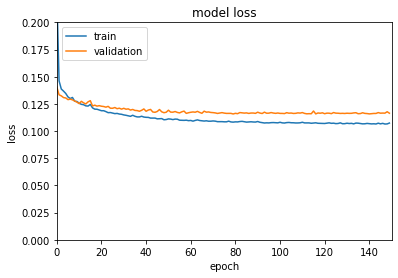

In [2]:
parsee = ct_sheet.sheet_names[2]
data = ct_sheet.parse(parsee)
data_features = data.loc[:, data.columns] 
data_features = data_features.drop(['ROI',11142,12142], axis=1)  

parsee2 = ct_sheet.sheet_names[3]
data2 = ct_sheet.parse(parsee2)
data_labels = data2.loc[:, data2.columns] 
data_labels = data_labels.drop(['ROI',11142,12142], axis=1)  
#Get rid of subject names to only have features now. #Need to remove ROIs. They don't convert to floats.
#Get rid of ctx_rh_Medial_wall and ctx_lh_Medial_wall, not needed for analysis.
#Have to standardize data. Scikit learn here. Need to create stratified K folds to avoid uneven distribution of risk groups.pcaCT1Y = PCA(n_components=150) #150 Features
scaler_filename = "IBIS_scaledSA1y.save"
scaler = joblib.load(scaler_filename)
scaled_data = scaler.transform(data_features)

scaler_filename2 = "IBIS_scaledSA2y.save"
scaler2 = joblib.load(scaler_filename2)
scaled_labels = scaler.transform(data_labels)
print(scaled_data.shape)
print(scaled_labels.shape)
X_train, X_test, Y_train, Y_test = train_test_split(scaled_data, scaled_labels, test_size=0.10, random_state=20)

#Size of encoded representation
#{'batch_size': 10, 'dropout': 0.15, 'encoded_layer_size': 25, 'epochs': 150, 'layer1_size': 100, 'layer2_size': 40}
input_size = 148
hidden_size = 100
hidden_size_2 = 40
encoding_dim = 25
dropout = 0.15

# Input Placeholder
input_data = Input(shape=(input_size,))
print(input_data)
# "encoded" is the encoded representation of the input
hidden_e_1 = Dense(hidden_size, activation='tanh')(input_data) 
hidden_e_2 = Dense(hidden_size_2, activation='tanh')(hidden_e_1)
dropout_layer = Dropout(dropout)(hidden_e_2)
encoded = Dense(encoding_dim, activation='tanh')(dropout_layer)
# "decoded" is the lossy reconstruction of the input
hidden_d_1 = Dense(hidden_size, activation='tanh')(encoded)
dropout_layer_d = Dropout(dropout)(hidden_d_1)
hidden_d_2 = Dense(hidden_size, activation='tanh')(dropout_layer_d)
decoded = Dense(input_size, activation='tanh')(hidden_d_2) 
# this model maps an input to its prediction
autoencoder = Model(input_data, decoded)
# configure our model to use mean_absolute_error loss function, and the Adam optimizer:
autoencoder.compile(optimizer='Adam', loss='mean_absolute_error')

ac = autoencoder.fit(X_train, Y_train,
epochs=150,
batch_size=10,
shuffle=True,
validation_data=(X_test, Y_test))

#print(ac.history.keys())
# "Loss"
plt.plot(ac.history['loss'])
plt.plot(ac.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, 150, 0.0, 0.2])
plt.show()